<h1>RQ2 - How do clients respond to in-range breaking updates?</h1>

<h2>Findings</h2>
<ul>
    <li><b>Finding) TODO</b></li>
</ul>

<h3>Load helper functions</h3>

In [908]:
%run _utils.ipynb

<h3>Load Greenkeeper In-Range Breaking Build <code>issues</code></h3>

In [658]:
issues = load_issues()

<h3>Load <code>all_issues</code></h3>
<p>NOTE that this includes every single issue from every single repo in the list of repos from the GK In-range breaking build issues set</p>

Count=2398438 (Project Count=12017) Median=55.0 Mean=199.58708496296913


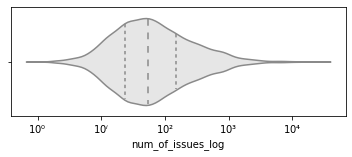

In [659]:
all_issues = load_all_issues()
counts = all_issues.groupby('repo_name')['id'].count()
print(f"Count={len(all_issues)} (Project Count={len(counts)}) Median={counts.median()} Mean={counts.mean()}")
for_plot = counts.to_frame(name='num_of_issues')
for_plot['placeholder'] = ''
for_plot['num_of_issues_log'] = np.log10(for_plot['num_of_issues'])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,2))
ax = sns.violinplot(
    data=for_plot,
    x='num_of_issues_log',
    y='placeholder',
    inner='quartile',
    palette=['0.9'],
    logscale=True
)
ax.set_ylabel('')
ax.xaxis.set_major_formatter(log10_func_formatter)
plt.show()

<h3>Create data sets of <code>non_gk_issues</code> and <code>gk_issues</code></h3>
<p>
    For analysis, we ignore gk_issues that we dont have all issues for, and remove the duplicate gk_issues from the all_issues data set
</p>

In [660]:
def filter_issues_for_analyses(all_issues, gk_issues):
    # Make copies
    gk_issues_for_analysis = gk_issues.copy()
    non_gk_issues_for_analysis = all_issues.copy()
    # Remove pull requests from all issues
    non_gk_issues_for_analysis = non_gk_issues_for_analysis[
        ~non_gk_issues_for_analysis['is_pull_request']
    ]
    # Filter out any issues that are GK in-range breakin gbuild issues
    non_gk_issues_for_analysis = non_gk_issues_for_analysis[
        ~non_gk_issues_for_analysis['id'].isin(gk_issues_for_analysis['id'])
    ]
    # Only analyze GK issues for projects we have all issues for
    gk_issues_for_analysis = gk_issues_for_analysis[
        gk_issues_for_analysis['repo_name'].isin(non_gk_issues_for_analysis['repo_name'])
    ]
    # Copy the html_url and body attributes over from all_issues to their respective rows on gk_issues
    gk_issues_for_analysis = gk_issues_for_analysis.merge(
        all_issues[['id', 'html_url', 'body']],
        how='left',
        on='id',
    )
    return non_gk_issues_for_analysis, gk_issues_for_analysis
    

non_gk_issues, gk_issues = filter_issues_for_analyses(all_issues, issues)

<h3><b><i>What proportion of in-range breaking build issue reports are closed (i.e., resolved)?</i></b></h3>
<p>
    Overall, in-range breaking build issue reports are closed 79.8% of the time (20.2% are never closed).
    <br>
    When comparing at the intra-project level, the median proportion of in-range breaking build issue reports closed by individual projects is 100% (median for other issues is 0.905). Projects are closing in-range breaking build issue reports at the same rate as other issues in the project (median ratio for gk to non-gk is 1.022).
</p>

In [661]:
proportions = (
    issues['state'].value_counts() / 
    issues['state'].count()
).to_frame(name='proportion')\
    .rename_axis('state')\
    .reset_index()
print('--All GK in-range breaking issue state proportions (not calculated per project)--')
proportions.head()

--All GK in-range breaking issue state proportions (not calculated per project)--


,state,proportion
0,closed,0.798242
1,open,0.201758


--Intra-project comparison for proportion of closed issues & proportion of closed GK in-range breaking build issues--
Proportion of closed issues      Count    Mean    STD    Min    25%    Median    75%    Max
-----------------------------  -------  ------  -----  -----  -----  --------  -----  -----
proportion_non_gk                 7290   0.826  0.209  0.026    0.7     0.905      1      1
proportion_gk                     7290   0.909  0.211  0.022    1       1          1      1



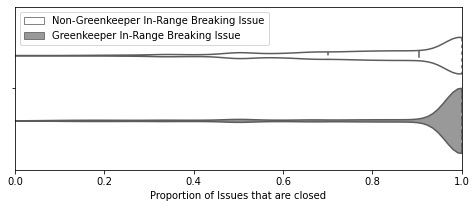

In [907]:
non_gk_issues__state_proportions = (
    (
        non_gk_issues.groupby('repo_name', observed=True)['state'].value_counts() / 
        non_gk_issues.groupby('repo_name')['state'].count()
    ).to_frame(name='proportion').reset_index()
)
gk_issues__state_proportions = (
    (
        gk_issues.groupby('repo_name')['state'].value_counts() / 
        gk_issues.groupby('repo_name')['state'].count()
    ).to_frame(name='proportion').reset_index()
)

project_issue__state_proportions = non_gk_issues__state_proportions.merge(
    gk_issues__state_proportions,
    how='inner',
    on=['repo_name', 'state'],
    suffixes=['_non_gk', '_gk'],
)
project_issue__state_proportions['ratio'] = project_issue__state_proportions['proportion_gk'] / project_issue__state_proportions['proportion_non_gk']
project_issue__state_proportions__closed = project_issue__state_proportions[project_issue__state_proportions['state'] == 'closed']

melted = pd.melt(
    project_issue__state_proportions__closed,
    id_vars='repo_name',
    value_vars=['proportion_non_gk', 'proportion_gk'],
    var_name='proportion_type',
    value_name='proportion',
)
melted['placeholder'] = ''
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
sns.violinplot(
    data=melted,
    x='proportion',
    y='placeholder',
    hue='proportion_type',
    split=False,
    inner='quartile',
    palette=['1', '0.6'],
    ax=ax,
)
ax.set_ylabel('')
ax.set_xlabel('Proportion of Issues that are closed')
ax.set_xlim(0, 1)
ax.legend(
    title='',
)
L = plt.legend(loc=2)
L.get_texts()[0].set_text('Non-Greenkeeper In-Range Breaking Issue')
L.get_texts()[1].set_text('Greenkeeper In-Range Breaking Issue')
print('--Intra-project comparison for proportion of closed issues & proportion of closed GK in-range breaking build issues--')
tfns(project_issue__state_proportions__closed, ['proportion_non_gk', 'proportion_gk'], title='Proportion of closed issues')
plt.show()

In [663]:
# TODO: Statistical test

<h4>Project ratio between proportion of closed non-gk issues and gk issues</h4>

--Intra-project comparison for ratio of a projects proportion of closed GK issues to proportion of closed non-gk issues--
         Count    Mean    STD    Min    25%    Median    75%    Max
-----  -------  ------  -----  -----  -----  --------  -----  -----
ratio     7290   1.224  0.729  0.022      1     1.022  1.321     19



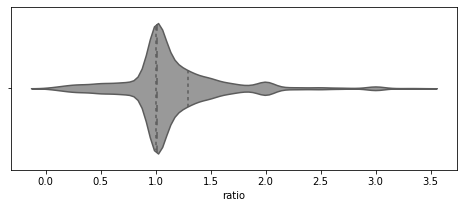

In [664]:
for_plot = project_issue__state_proportions__closed[['ratio']].copy()
for_plot = filter_outliers(for_plot, col='ratio', threshold=3)
for_plot['placeholder'] = ''
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
ax = sns.violinplot(
    data=for_plot,
    x='ratio',
    y='placeholder',
    inner='quartile',
    palette=['0.6'],
    scale='width'
)
ax.set_ylabel('')
# ax.set_xlim(0, 2)
print('--Intra-project comparison for ratio of a projects proportion of closed GK issues to proportion of closed non-gk issues--')
tfns(project_issue__state_proportions__closed, ['ratio'])
plt.show()

<h3><b><i>How long does it take for in-range breaking build issue reports to be closed (i.e., resolved)?</i></b></h3>
<ul>
    <li>Overall, in-range breaking build issue reports are closed in a median of 4 days 11 hours.</li>
    <li>When comparing at the intra-project level, the median time to close in-range breaking build issues is 13 days 21 hours, while the median time to close other issues is 6 days 6 hours.</li>
    <li>At the project level, in-range breaking build issue reports stay open with a medain value of 1.575x as long as other issues.</li>
</ul>

--All GK in-range breaking issue state proportions (not calculated per project)--
                 Count  Mean              STD               Min              25%              Median           75%               Max
-------------  -------  ----------------  ----------------  ---------------  ---------------  ---------------  ----------------  ------------------
time_to_close    98341  43 days 04:48:29  98 days 22:44:48  0 days 00:00:04  0 days 09:58:19  4 days 11:04:25  35 days 07:48:16  1219 days 02:01:10



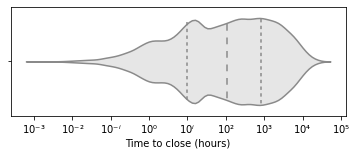

In [665]:
closed_issues = issues[issues['state'] == 'closed'][['created_at', 'closed_at']]
closed_issues['time_to_close'] = closed_issues['closed_at'] - closed_issues['created_at']
closed_issues['time_to_close_hours'] = closed_issues['time_to_close'] / np.timedelta64(1, 'h')
closed_issues['log_time_to_close_hours'] = np.log10(closed_issues['time_to_close_hours'])
closed_issues['placeholder'] = ''
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,2))
ax = sns.violinplot(
    data=closed_issues,
    x='log_time_to_close_hours',
    y='placeholder',
    inner='quartile',
    palette=['0.9'],
)
ax.set_ylabel('')
ax.set_xlabel('Time to close (hours)')
ax.xaxis.set_major_formatter(log10_func_formatter)
print('--All GK in-range breaking issue state proportions (not calculated per project)--')
tfns(closed_issues, ['time_to_close'])
plt.show()

/home/local/SAIL/benjamin/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


--Intra-project comparison for median time to close issues & median time to close GK in-range breaking build issues--
Median time to close issue      Count  Mean              STD                Min              25%              Median            75%               Max
----------------------------  -------  ----------------  -----------------  ---------------  ---------------  ----------------  ----------------  ------------------
median_non_gk                    7290  49 days 00:04:46  127 days 16:11:47  0 days 00:00:03  1 days 04:16:50  6 days 05:58:38   28 days 19:27:22  2097 days 11:47:18
median_gk                        7710  61 days 23:32:22  118 days 17:34:01  0 days 00:00:28  1 days 16:36:01  13 days 21:29:07  63 days 18:26:16  1130 days 03:37:18

Saving figure intra_project_median_time_to_close


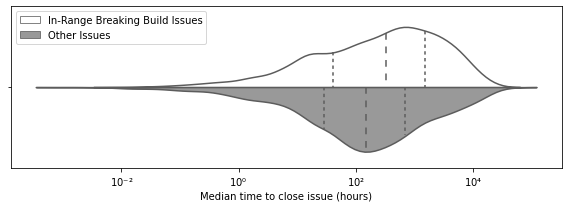

	Mann-Whitney: statistic=27423757.0 pvalue=4.57059314566935e-17
	Cliff'a Delta: delta=-0.9739166208252795 size=large



In [909]:
# Calculate mean and median intra-project time_to_close for Non-GK issues
non_gk_issues__closed = non_gk_issues[non_gk_issues['state'] == 'closed'].copy()
non_gk_issues__closed['time_to_close'] = (
    non_gk_issues__closed['closed_at'] - non_gk_issues__closed['created_at']
).dt.total_seconds()  # Have to convert to seconds to calculate mean and median
project__non_gk_issue__time_to_close = (
    non_gk_issues__closed
        .groupby('repo_name')['time_to_close']
        .agg(['mean', 'median'])
        .reset_index()
)
project__non_gk_issue__time_to_close['mean'] = pd.to_timedelta(
    project__non_gk_issue__time_to_close['mean'],
    unit='s'
)
project__non_gk_issue__time_to_close['mean_hours_log'] = np.log10(
    project__non_gk_issue__time_to_close['mean'] / np.timedelta64(1, 'h')
)
project__non_gk_issue__time_to_close['median'] = pd.to_timedelta(
    project__non_gk_issue__time_to_close['median'],
    unit='s'
)
project__non_gk_issue__time_to_close['median_hours_log'] = np.log10(
    project__non_gk_issue__time_to_close['median'] / np.timedelta64(1, 'h')
)

# Calculate mean and median intra-project time_to_close for GK issues
gk_issues__closed = gk_issues[gk_issues['state'] == 'closed'].copy()
gk_issues__closed['time_to_close'] = (
    gk_issues__closed['closed_at'] - gk_issues__closed['created_at']
).dt.total_seconds()  # Have to convert to seconds to calculate mean and median
project__gk_issue__time_to_close = (
    gk_issues__closed
        .groupby('repo_name')['time_to_close']
        .agg(['mean', 'median'])
        .reset_index()
)
project__gk_issue__time_to_close['mean'] = pd.to_timedelta(
    project__gk_issue__time_to_close['mean'],
    unit='s'
)
project__gk_issue__time_to_close['mean_hours_log'] = np.log10(
    project__gk_issue__time_to_close['mean'] / np.timedelta64(1, 'h')
)
project__gk_issue__time_to_close['median'] = pd.to_timedelta(
    project__gk_issue__time_to_close['median'],
    unit='s'
)
project__gk_issue__time_to_close['median_hours_log'] = np.log10(
    project__gk_issue__time_to_close['median'] / np.timedelta64(1, 'h')
)

# Merge the two
project__all_issues__time_to_close = project__non_gk_issue__time_to_close.merge(
    project__gk_issue__time_to_close,
    how='inner',
    on=['repo_name'],
    suffixes=['_non_gk', '_gk'],
)

# Melt for violine plot
melted = pd.melt(
    project__all_issues__time_to_close,
    id_vars='repo_name',
    value_vars=['median_hours_log_gk', 'median_hours_log_non_gk'],
    var_name='issue_type',
    value_name='median_time_to_close_hours_log',
)

melted['placeholder'] = ''
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
sns.violinplot(
    data=melted,
    x='median_time_to_close_hours_log',
    y='placeholder',
    hue='issue_type',
    split=True,
    inner='quartile',
    palette=['1', '0.6'],
    ax=ax,
)
ax.set_ylabel('')
ax.set_xlabel('Median time to close issue (hours)')
ax.xaxis.set_major_formatter(log10_func_formatter)
ax.legend(
    title='',
)
L = plt.legend()
L.get_texts()[0].set_text('In-Range Breaking Build Issues')
L.get_texts()[1].set_text('Other Issues')
print('--Intra-project comparison for median time to close issues & median time to close GK in-range breaking build issues--')
tfns(project__all_issues__time_to_close, ['median_non_gk', 'median_gk'], title='Median time to close issue')
save_fig('intra_project_median_time_to_close')
plt.show()

# Use mann-whitney test because wilcoxon test requires same length
(statistic, pvalue) = mannwhitneyu(project__all_issues__time_to_close['median_gk'], project__all_issues__time_to_close['median_non_gk'])
(delta, size) = cliffsDelta(project__all_issues__time_to_close['median_gk'], project__all_issues__time_to_close['median_non_gk'])
print(f'''\
\tMann-Whitney: statistic={statistic} pvalue={pvalue}
\tCliff'a Delta: delta={delta} size={size}
''')

--Intra-project comparison for ratio of median time to close GK issues vs median time to close non-GK issues--
                Count     Mean      STD    Min    25%    Median     75%     Max
------------  -------  -------  -------  -----  -----  --------  ------  ------
median_ratio     7290  808.67   12013.5      0  0.239     1.575  12.023  566938
mean_ratio       7290  616.496  11735.8      0  0.141     0.698   3.317  623097



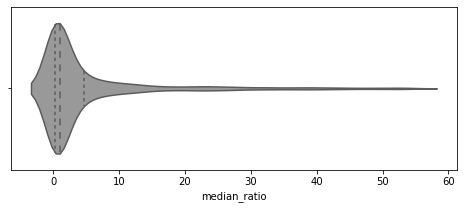

In [667]:
project__all_issues__time_to_close['median_ratio'] = (
    project__all_issues__time_to_close['median_gk'] / 
    project__all_issues__time_to_close['median_non_gk']
)
project__all_issues__time_to_close['mean_ratio'] = (
    project__all_issues__time_to_close['mean_gk'] / 
    project__all_issues__time_to_close['mean_non_gk']
)
for_plot = project__all_issues__time_to_close[['median_ratio']].copy()
# Remove outliers and extemes for plot
for_plot = for_plot[for_plot['median_ratio'] < 100]
for_plot = filter_outliers(for_plot, col='median_ratio', threshold=3)

for_plot['placeholder'] = ''
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
sns.violinplot(
    data=for_plot,
    x='median_ratio',
    y='placeholder',
    inner='quartile',
    palette=['0.6'],
)
ax.set_ylabel('')
print('--Intra-project comparison for ratio of median time to close GK issues vs median time to close non-GK issues--')
tfns(project__all_issues__time_to_close, ['median_ratio', 'mean_ratio'])
plt.show()

<h2><b>Comments</b></h2>

In [668]:
comments = load_comments()
NOT_CLASSIFIED = 'Other'
# Set all comments to 'Not Classified'
comments['comment_classification'] = NOT_CLASSIFIED

<h3><b><i>How many comments to in-range breaking build issue reports have in total and from actual developers?</i></b></h3>

In [669]:
proportions = (
    comments['comment_user_type'].value_counts() / 
    comments['comment_user_type'].count()
).to_frame(name='proportion')\
    .rename_axis('comment_user_type')\
    .reset_index()
print(proportions.head())

def get_issue_comment_count(df):
    return df.groupby('comment_issue_id')['comment_id']\
        .count()\
        .to_frame(name='num_of_comments')\
        .reset_index()

counts = get_issue_comment_count(comments)
tfns(counts, ['num_of_comments'], should_round=False, title='Number of comments on In-Range issues')

user_counts = get_issue_comment_count(comments[comments['comment_user_type'] == 'User'])
tfns(user_counts, ['num_of_comments'], should_round=False, title='Number of user comments on In-Range issues')

bot_counts = get_issue_comment_count(comments[comments['comment_user_type'] == 'Bot'])
tfns(bot_counts, ['num_of_comments'], should_round=False, title='Number of bot comments on In-Range issues')


  comment_user_type  proportion
0               Bot    0.970669
1              User    0.029331
Number of comments on In-Range issues      Count     Mean      STD    Min    25%    Median    75%    Max
---------------------------------------  -------  -------  -------  -----  -----  --------  -----  -----
num_of_comments                            99581  3.67163  5.40044      1      1         2      4     30

Number of user comments on In-Range issues      Count     Mean       STD    Min    25%    Median    75%    Max
--------------------------------------------  -------  -------  --------  -----  -----  --------  -----  -----
num_of_comments                                  9854  1.08829  0.646108      1      1         1      1     28

Number of bot comments on In-Range issues      Count     Mean      STD    Min    25%    Median    75%    Max
-------------------------------------------  -------  -------  -------  -----  -----  --------  -----  -----
num_of_comments                     

<h3>User Comments Analysis</h3>

In [670]:
users_comments = comments[comments['comment_user_type'] == 'User'].copy().reset_index(drop=True)
issues_with_user_comment = \
    gk_issues[gk_issues['id']\
        .isin(users_comments['comment_issue_id'])]\
        .copy()\
        .reset_index(drop=True)
percent_of_issues_with_user_comment = f'{calculate_percent(len(issues_with_user_comment), len(gk_issues))}%'
print(f'{percent_of_issues_with_user_comment} of in-range issues have a comment from a user.')

9.3% of in-range issues have a comment from a user.


<h3><b><i>How long does it take for users to comment?</i></b></h3>

                   Count  Mean              STD               Min              25%              Median           75%               Max
---------------  -------  ----------------  ----------------  ---------------  ---------------  ---------------  ----------------  ------------------
time_to_comment     9652  25 days 17:24:11  65 days 08:20:06  0 days 00:00:01  0 days 08:17:24  2 days 12:57:58  18 days 16:46:52  1039 days 05:34:55



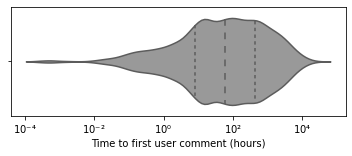

In [792]:
users_comments_simplified = users_comments[['comment_issue_id', 'comment_created_at']]
users_comments_simplified = \
    users_comments_simplified\
        .groupby('comment_issue_id')['comment_created_at']\
        .min()\
        .to_frame()\
        .reset_index()
issues_simplified = gk_issues[['id', 'created_at', 'repo_name']]

gk_issues_with_first_user_comments = issues_simplified.merge(
    users_comments_simplified,
    left_on='id',
    right_on='comment_issue_id'
)
gk_issues_with_first_user_comments['time_to_comment'] = \
    gk_issues_with_first_user_comments['comment_created_at'] - gk_issues_with_first_user_comments['created_at']

gk_issues_with_first_user_comments['time_to_comment_hours'] = \
    gk_issues_with_first_user_comments['time_to_comment'] / np.timedelta64(1, 'h')
gk_issues_with_first_user_comments = \
    gk_issues_with_first_user_comments[~(gk_issues_with_first_user_comments['time_to_comment_hours'] == 0)]
gk_issues_with_first_user_comments['log_time_to_comment_hours'] = \
    np.log10(gk_issues_with_first_user_comments['time_to_comment_hours'])
gk_issues_with_first_user_comments['placeholder'] = ''
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,2))
ax = sns.violinplot(
    data=gk_issues_with_first_user_comments,
    x='log_time_to_comment_hours',
    y='placeholder',
    inner='quartile',
    palette=['0.6'],
)
ax.set_ylabel('')
ax.set_xlabel('Time to first user comment (hours)')
ax.xaxis.set_major_formatter(log10_func_formatter)
tfns(merged, ['time_to_comment'])
plt.show()

<h3><b>Intra-project comparison of time until first user comment</b></h3>

In [681]:
# Writing out CSV for creating non_gkirbbi_comments
# for_csv = non_gk_issues[['id', 'repo_name', 'comments_url']]
# for_csv.to_csv(f'../csv/issues_to_collect_comments_for.csv', index=False)

In [822]:
non_gkirbbi_comments = load_non_gkirbbi_comments()
print(f'Count of unique projects: {non_gkirbbi_comments["repo_name"].nunique()}')

# Determine time until first user comment on non-gk issues
non_gkirbbi_user_comments = non_gkirbbi_comments.loc[
    (non_gkirbbi_comments['user_type'] == 'User') &
    (~non_gkirbbi_comments['issue_id'].isin(gk_issues_with_first_user_comments['id']))
]
non_gkirbbi_first_user_comments = (
    non_gkirbbi_user_comments
        .groupby('issue_id')['created_at']
        .min()
        .to_frame()
        .reset_index()   
)
non_gkirbbi_with_first_comment = non_gkirbbi_first_user_comments.merge(
    non_gk_issues[['id', 'repo_name', 'created_at']],
    how='inner',
    left_on='issue_id',
    right_on='id',
    suffixes=['_comment', '_issue']
)
non_gkirbbi_with_first_comment['time_to_comment'] = \
    non_gkirbbi_with_first_comment['created_at_comment'] - non_gkirbbi_with_first_comment['created_at_issue']

# Find what the mean and median time to first user comment on non-gk issues at project level
non_gkirbbi_with_first_comment__simplified = \
    non_gkirbbi_with_first_comment[['id', 'repo_name', 'time_to_comment']].copy()

non_gkirbbi_with_first_comment__simplified['time_to_comment'] = \
    non_gkirbbi_with_first_comment__simplified['time_to_comment'].dt.total_seconds()  # Have to convert to seconds to calculate mean and median

projects__non_gkirbbi_with_first_user_comment = (
    non_gkirbbi_with_first_comment__simplified
        .groupby('repo_name')['time_to_comment']
        .agg(['mean', 'median'])
        .reset_index()
)

projects__non_gkirbbi_with_first_user_comment = \
    projects__non_gkirbbi_with_first_user_comment[~pd.isna(projects__non_gkirbbi_with_first_user_comment['median'])]

projects__non_gkirbbi_with_first_user_comment['mean'] = pd.to_timedelta(
    projects__non_gkirbbi_with_first_user_comment['mean'],
    unit='s'
)
projects__non_gkirbbi_with_first_user_comment['mean_hours_log'] = np.log10(
    projects__non_gkirbbi_with_first_user_comment['mean'] / np.timedelta64(1, 'h')
)
projects__non_gkirbbi_with_first_user_comment['median'] = pd.to_timedelta(
    projects__non_gkirbbi_with_first_user_comment['median'],
    unit='s'
)
projects__non_gkirbbi_with_first_user_comment['median_hours_log'] = np.log10(
    projects__non_gkirbbi_with_first_user_comment['median'] / np.timedelta64(1, 'h')
)

Count of unique projects: 1258


In [824]:
gk_issues_with_first_user_comments__simplified = \
    gk_issues_with_first_user_comments[['id', 'repo_name', 'time_to_comment']].copy()

gk_issues_with_first_user_comments__simplified['time_to_comment'] = \
    gk_issues_with_first_user_comments__simplified['time_to_comment'].dt.total_seconds()  # Have to convert to seconds to calculate mean and median

projects__gk_issues_with_first_user_comments = (
    gk_issues_with_first_user_comments__simplified
        .groupby('repo_name')['time_to_comment']
        .agg(['mean', 'median'])
        .reset_index()
)
projects__gk_issues_with_first_user_comments['mean'] = pd.to_timedelta(
    projects__gk_issues_with_first_user_comments['mean'],
    unit='s'
)
projects__gk_issues_with_first_user_comments['mean_hours_log'] = np.log10(
    projects__gk_issues_with_first_user_comments['mean'] / np.timedelta64(1, 'h')
)
projects__gk_issues_with_first_user_comments['median'] = pd.to_timedelta(
    projects__gk_issues_with_first_user_comments['median'],
    unit='s'
)
projects__gk_issues_with_first_user_comments['median_hours_log'] = np.log10(
    projects__gk_issues_with_first_user_comments['median'] / np.timedelta64(1, 'h')
)

--Intra-project comparison for median time to first user comment on non-GK issues & median time to first user comment on GK in-range breaking build issues--
                 Count  Mean              STD               Min              25%              Median           75%               Max
-------------  -------  ----------------  ----------------  ---------------  ---------------  ---------------  ----------------  ------------------
median_non_gk      458  19 days 20:50:07  84 days 21:24:15  0 days 00:00:41  0 days 04:52:51  0 days 16:25:52  3 days 00:29:13   1139 days 22:27:21
median_gk          458  25 days 01:36:42  63 days 22:26:09  0 days 00:00:06  0 days 07:55:06  2 days 06:41:50  17 days 03:40:50  515 days 04:38:21



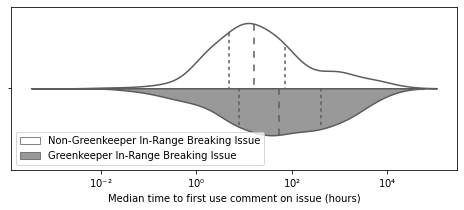

In [830]:
# Merge gk and non-gk project time to user comment by repo_name
project__all_issues__time_to_comment = projects__non_gkirbbi_with_first_user_comment.merge(
    projects__gk_issues_with_first_user_comments,
    how='inner',
    on=['repo_name'],
    suffixes=['_non_gk', '_gk'],
)
# Melt for violine plot
melted = pd.melt(
    project__all_issues__time_to_comment,
    id_vars='repo_name',
    value_vars=['median_hours_log_gk', 'median_hours_log_non_gk'],
    var_name='issue_type',
    value_name='median_time_to_comment_hours_log',
)

melted['placeholder'] = ''
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
sns.violinplot(
    data=melted,
    x='median_time_to_comment_hours_log',
    y='placeholder',
    hue='issue_type',
    split=True,
    inner='quartile',
    palette=['1', '0.6'],
    ax=ax,
)
ax.set_ylabel('')
ax.set_xlabel('Median time to first use comment on issue (hours)')
ax.xaxis.set_major_formatter(log10_func_formatter)
ax.legend(
    title='',
)
L = plt.legend()
L.get_texts()[0].set_text('Non-Greenkeeper In-Range Breaking Issue')
L.get_texts()[1].set_text('Greenkeeper In-Range Breaking Issue')
print('--Intra-project comparison for median time to first user comment on non-GK issues & median time to first user comment on GK in-range breaking build issues--')
tfns(project__all_issues__time_to_comment, ['median_non_gk', 'median_gk'], title='')
plt.show()

--Intra-project comparison for ratio of median time to first user comment on GK issues vs non-GK issues--
                Count     Mean      STD    Min    25%    Median     75%     Max
------------  -------  -------  -------  -----  -----  --------  ------  ------
median_ratio      458  778.275  13892.5      0  0.331     2.987  24.141  296580
mean_ratio        458  734.819  13889.6      0  0.052     0.474   2.276  296580



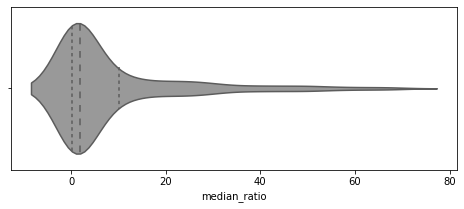

In [831]:
project__all_issues__time_to_comment['median_ratio'] = (
    project__all_issues__time_to_comment['median_gk'] / 
    project__all_issues__time_to_comment['median_non_gk']
)
project__all_issues__time_to_comment['mean_ratio'] = (
    project__all_issues__time_to_comment['mean_gk'] / 
    project__all_issues__time_to_comment['mean_non_gk']
)
for_plot = project__all_issues__time_to_comment[['median_ratio']].copy()
# Remove outliers and extemes for plot
for_plot = for_plot[for_plot['median_ratio'] < 100]
for_plot = filter_outliers(for_plot, col='median_ratio', threshold=3)

for_plot['placeholder'] = ''
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
sns.violinplot(
    data=for_plot,
    x='median_ratio',
    y='placeholder',
    inner='quartile',
    palette=['0.6'],
)
ax.set_ylabel('')
print('--Intra-project comparison for ratio of median time to first user comment on GK issues vs non-GK issues--')
tfns(project__all_issues__time_to_comment, ['median_ratio', 'mean_ratio'])
plt.show()

<h3>Bot Comments Analysis</h3>

<h3><b><i>How many issues are eventually resolved by the provider releasing a new version?</i></b></h3>

In [892]:
gk_comments = comments.loc[
    (
        (comments['comment_user_type'] == 'Bot') &
        (comments['comment_user_login'] == 'greenkeeper[bot]')
    )
]
failing_with_new_release_regex = 'Your tests are still failing with this version'
passing_with_new_release_regex = 'Your tests are passing again with this version'

def comment_group_saw_new_release(comment_group):
    new_release_comments = comment_group[
        (comment_group['comment_body'].str.contains(failing_with_new_release_regex)) |
        (comment_group['comment_body'].str.contains(passing_with_new_release_regex))
    ]
    return len(new_release_comments) > 0

gk_new_release_comments = gk_comments.groupby('comment_issue_id').filter(comment_group_saw_new_release)
issues_with_new_release_count = gk_new_release_comments['comment_issue_id'].nunique()
proportion = calculate_percent(issues_with_new_release_count, len(gk_issues))
print(f'{proportion}% ({issues_with_new_release_count}) of issues saw a new release of the dependency')


def issue_has_passing_with_new_release_comment(comment_group):
    new_passing_release_comments = comment_group[
        comment_group['comment_body'].str.contains(passing_with_new_release_regex)
    ]
    return len(new_passing_release_comments) > 0

def issue_has_only_failing_new_release_comments(comment_group):
    if issue_has_passing_with_new_release_comment(comment_group):
        return False
    new_failing_release_comments = comment_group[
        comment_group['comment_body'].str.contains(failing_with_new_release_regex)
    ]
    return len(new_failing_release_comments) > 0

passing_with_new_release = \
    gk_new_release_comments.groupby('comment_issue_id').filter(issue_has_passing_with_new_release_comment)
issues_with_passing_new_release_count = \
    passing_with_new_release['comment_issue_id'].nunique()
proportion_of_new_releases = \
    calculate_percent(issues_with_passing_new_release_count, issues_with_new_release_count)
proportion_all = \
    calculate_percent(issues_with_passing_new_release_count, len(gk_issues))
print(f'''\
{proportion_of_new_releases}% ({issues_with_passing_new_release_count}) of issues that saw a new release saw \
at least on passing release ({proportion_all}% of all issues)\
''')

only_failing_new_release = \
    gk_new_release_comments.groupby('comment_issue_id').filter(issue_has_only_failing_new_release_comments)
issues_with_only_failing_new_release_count = \
    only_failing_new_release['comment_issue_id'].nunique()
proportion_of_new_releases = \
    calculate_percent(issues_with_only_failing_new_release_count, issues_with_new_release_count)
proportion_all = \
    calculate_percent(issues_with_only_failing_new_release_count, len(gk_issues))
print(f'''\
{proportion_of_new_releases}% ({issues_with_only_failing_new_release_count}) of issues that saw a new release saw \
only failing releases ({proportion_all}% of all issues)
''')

37.87% (39298) of issues saw a new release of the dependency
18.72% (7355) of issues that saw a new release saw at least on passing release (7.09% of all issues)
81.28% (31943) of issues that saw a new release saw only failing releases (30.78% of all issues)



<h4>Issues with only failing new releases - how did the pin attempt turn out?</h4>

In [750]:
pin_attempts_from_only_failing_new_release = only_failing_new_release[only_failing_new_release['comment_body'].str.contains('after pinning to', case=False)].copy()
pin_fail_regex = '|'.join([
    "your tests are still failing",
])
pin_success_string = '|'.join([
    "your tests are passing again"
])
pin_attempts_from_only_failing_new_release.loc[
    pin_attempts_from_only_failing_new_release['comment_body'].str.contains(pin_success_string, case=False),
    'pin_status'
] = 'success'
pin_attempts_from_only_failing_new_release.loc[
    pin_attempts_from_only_failing_new_release['comment_body'].str.contains(pin_fail_string, case=False),
    'pin_status'
] = 'failure'

proportions = (
    pin_attempts_from_only_failing_new_release['pin_status'].value_counts() / 
    pin_attempts_from_only_failing_new_release['pin_status'].count()
).to_frame(name='proportion')\
    .rename_axis('pin_status')\
    .reset_index()
print('--For issues with only failing new releases, how did the pin attempt turn out?--')
proportions.head()

--For issues with only failing new releases, how did the pin attempt turn out?--


,pin_status,proportion
0,failure,0.786456
1,success,0.213544


<h4>Issues with a passing new release - how did the pin attempt turn out?</h4>

In [751]:
pin_attempts_from_passing_with_new_release = \
    passing_with_new_release[passing_with_new_release['comment_body'].str.contains('after pinning to', case=False)].copy()
pin_fail_regex = '|'.join([
    "your tests are still failing",
])
pin_success_string = '|'.join([
    "your tests are passing again"
])
pin_attempts_from_passing_with_new_release.loc[
    pin_attempts_from_passing_with_new_release['comment_body'].str.contains(pin_success_string, case=False),
    'pin_status'
] = 'success'
pin_attempts_from_passing_with_new_release.loc[
    pin_attempts_from_passing_with_new_release['comment_body'].str.contains(pin_fail_string, case=False),
    'pin_status'
] = 'failure'

proportions = (
    pin_attempts_from_passing_with_new_release['pin_status'].value_counts() / 
    pin_attempts_from_passing_with_new_release['pin_status'].count()
).to_frame(name='proportion')\
    .rename_axis('pin_status')\
    .reset_index()
print('--For issues with passing new releases, how did the pin attempt turn out?--')
proportions.head()

--For issues with passing new releases, how did the pin attempt turn out?--


,pin_status,proportion
0,success,0.634492
1,failure,0.365508


<h2><b>Pinning</b></h2>

<h3><b><i>How successful is auto-pinning the dependency?</i></b></h3>

In [672]:
pinning_comments = comments.loc[
    (
        (comments['comment_user_type'] == 'Bot') &
        (comments['comment_user_login'] == 'greenkeeper[bot]') &
        (comments['comment_body'].str.contains('After pinning to', case=False))
    )
][['comment_issue_id', 'comment_url', 'comment_body']]
issue_pin_status = pinning_comments.merge(
    gk_issues[['id', 'url', 'title', 'html_url', 'body']],
    left_on='comment_issue_id',
    right_on='id'
)
# Re-order columns
issue_pin_status = issue_pin_status[['id', 'url', 'title', 'html_url', 'body', 'comment_issue_id', 'comment_url', 'comment_body']]
issue_pin_status['pin_status'] = 'unknown'
pin_fail_regex = '|'.join([
    "your tests are still failing",
])
pin_success_string = '|'.join([
    "your tests are passing again"
])
issue_pin_status.loc[
    issue_pin_status['comment_body'].str.contains(pin_success_string, case=False),
    'pin_status'
] = 'success'
issue_pin_status.loc[
    issue_pin_status['comment_body'].str.contains(pin_fail_string, case=False),
    'pin_status'
] = 'failure'

issue_pin_status['pin_status'].value_counts()

proportions = (
    issue_pin_status['pin_status'].value_counts() / 
    issue_pin_status['pin_status'].count()
).to_frame(name='proportion')\
    .rename_axis('pin_status')\
    .reset_index()
print('--How successful is pinning the dependency?--')
proportions.head()

--How successful is pinning the dependency?--


,pin_status,proportion
0,failure,0.676202
1,success,0.323798


<h4>Write out cases for manual analysis</h4>

In [922]:
failed_pins = issue_pin_status[issue_pin_status['pin_status'] == 'failure']
# failed_pins.info()
sample_failed_pins = failed_pins.sample(n=800, random_state=42)
sample_failed_pins.to_csv(f'./manual_analysis/failed_pins/sample_failed_pins.csv', index=False)

,id
42748,390203749
37627,410052359
49392,367441775
63850,296191829
42737,390325270


In [921]:
gk_issues.loc[gk_issues['body'].str.contains('travis-ci.com', na=False, regex=False)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9545 entries, 0 to 101619
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   id                         9545 non-null   int64              
 1   number                     9545 non-null   int64              
 2   url                        9545 non-null   object             
 3   title                      9545 non-null   object             
 4   state                      9545 non-null   category           
 5   is_locked                  9545 non-null   bool               
 6   created_at                 9545 non-null   datetime64[ns, UTC]
 7   updated_at                 9545 non-null   datetime64[ns, UTC]
 8   closed_at                  7838 non-null   datetime64[ns, UTC]
 9   user_login                 9545 non-null   category           
 10  labels                     9545 non-null   category           
 11  nu

<h4>Do success/fail pins predict whether a new release will fix the issue? (basically the inverse of the previous section)</h4>

In [773]:
succ_pin_issue_ids = issue_pin_status[issue_pin_status['pin_status'] == 'success']['id'].unique()
fail_pin_issues_ids = issue_pin_status[issue_pin_status['pin_status'] == 'failure']['id'].unique()

gk_comments = comments.loc[
    (
        (comments['comment_user_type'] == 'Bot') &
        (comments['comment_user_login'] == 'greenkeeper[bot]')
    )
]
succ_pin_gk_comments = gk_comments[gk_comments['comment_issue_id'].isin(succ_pin_issue_ids)]
fail_pin_gk_comments = gk_comments[gk_comments['comment_issue_id'].isin(fail_pin_issues_ids)]

failing_with_new_release_regex = 'Your tests are still failing with this version'
passing_with_new_release_regex = 'Your tests are passing again with this version'


def comment_group_saw_new_release(comment_group):
    new_release_comments = comment_group[
        (comment_group['comment_body'].str.contains(failing_with_new_release_regex)) |
        (comment_group['comment_body'].str.contains(passing_with_new_release_regex))
    ]
    return len(new_release_comments) > 0
        

succ_pin_comments_with_new_release = \
    succ_pin_gk_comments\
        .groupby('comment_issue_id')\
        .filter(comment_group_saw_new_release)

fail_pin_comments_with_new_release = \
    fail_pin_gk_comments\
        .groupby('comment_issue_id')\
        .filter(comment_group_saw_new_release)

def issue_has_passing_with_new_release_comment(comment_group):
    new_passing_release_comments = comment_group[
        comment_group['comment_body'].str.contains(passing_with_new_release_regex)
    ]
    return len(new_passing_release_comments) > 0

def issue_has_only_failing_new_release_comments(comment_group):
    if issue_has_passing_with_new_release_comment(comment_group):
        return False
    new_failing_release_comments = comment_group[
        comment_group['comment_body'].str.contains(failing_with_new_release_regex)
    ]
    return len(new_failing_release_comments) > 0

print('SUCCESSFUL PINS')

succ_pin_comments_with_new_release_count = succ_pin_comments_with_new_release['comment_issue_id'].nunique()

passing_with_new_release = succ_pin_comments_with_new_release.groupby('comment_issue_id').filter(issue_has_passing_with_new_release_comment)
issues_with_passing_new_release_count = passing_with_new_release['comment_issue_id'].nunique()
proportion = calculate_percent(issues_with_passing_new_release_count, succ_pin_comments_with_new_release_count)
print(f'{proportion}% ({issues_with_passing_new_release_count}/{succ_pin_comments_with_new_release_count}) \
of issues with a successful pin attempt also eventually see a new passing release of the dependency')

only_failing_new_release = succ_pin_comments_with_new_release.groupby('comment_issue_id').filter(issue_has_only_failing_new_release_comments)
issues_with_only_failing_new_release_count = only_failing_new_release['comment_issue_id'].nunique()
proportion = calculate_percent(issues_with_only_failing_new_release_count, succ_pin_comments_with_new_release_count)
print(f'''\
{proportion}% ({issues_with_only_failing_new_release_count}/{succ_pin_comments_with_new_release_count}) \
of issues with a successful pin attempt only see new failing releases of the dependency'
(i.e. none of the dependencies new releases ever pass the clients pipeline )
''')

print()
print('FAIL PINS')

fail_pin_comments_with_new_release_count = fail_pin_comments_with_new_release['comment_issue_id'].nunique()

passing_with_new_release = fail_pin_comments_with_new_release.groupby('comment_issue_id').filter(issue_has_passing_with_new_release_comment)
issues_with_passing_new_release_count = passing_with_new_release['comment_issue_id'].nunique()
proportion = calculate_percent(issues_with_passing_new_release_count, fail_pin_comments_with_new_release_count)
print(f'{proportion}% ({issues_with_passing_new_release_count}/{fail_pin_comments_with_new_release_count}) \
of issues with a failing pin attempt also eventually see a new passing release of the dependency')

only_failing_new_release = fail_pin_comments_with_new_release.groupby('comment_issue_id').filter(issue_has_only_failing_new_release_comments)
issues_with_only_failing_new_release_count = only_failing_new_release['comment_issue_id'].nunique()
proportion = calculate_percent(issues_with_only_failing_new_release_count, fail_pin_comments_with_new_release_count)
print(f'''\
{proportion}% ({issues_with_only_failing_new_release_count}/{fail_pin_comments_with_new_release_count}) \
of issues with a failing pin attempt only see new failing releases of the dependency'
(i.e. none of the dependencies new releases ever pass the clients pipeline )
''')


SUCCESSFUL PINS
38.1% (2980/7822) of issues with a successful pin attempt also eventually see a new passing release of the dependency
61.9% (4842/7822) of issues with a successful pin attempt only see new failing releases of the dependency'
(i.e. none of the dependencies new releases ever pass the clients pipeline )


FAIL PINS
8.83% (1757/19909) of issues with a failing pin attempt also eventually see a new passing release of the dependency
91.17% (18152/19909) of issues with a failing pin attempt only see new failing releases of the dependency'
(i.e. none of the dependencies new releases ever pass the clients pipeline )



<h2><b>Code Changes</b></h2>

In [832]:
commits = load_commits()
gk_commits = (
    commits[commits['issue_id']
        .isin(gk_issues['id'])]
        .reset_index(drop=True)
)
issues_with_commit = (
    gk_issues[gk_issues['id']
        .isin(gk_commits['issue_id'])]
)

<h3><b><i>Can we tell when clients take the pin approach?</i></b></h3>

In [879]:
bens_collected_commits = load_bens_collected_commits()

In [891]:
def is_potential_pin(issue_commit_changes):
    result = (
        issue_commit_changes['stats_total'].max() == 2 and
        len(issue_commit_changes[issue_commit_changes['message'].str.contains('pin')]) > 0
    )
    return result
temp = (
    succ_pin_issues_with_commit__merged
        .groupby(['id', 'commit_sha'])
        .filter(is_potential_pin)
)
temp[['url_issue', 'message']]

,url_issue,message
0,https://api.github.com/repos/adobe/aio-lib-template/issues/14,fix: pin swagger-client to 3.9.6\n\ncloses #14
19,https://api.github.com/repos/webcompat/webcompat.com/issues/3235,Merge pull request #3237 from webcompat/greenkeeper/yargs-pin-15.2.0\n\nFixes #3235 - pin yargs to 15.2.0
387,https://api.github.com/repos/k-yle/sACN/issues/5,Merge pull request #6 from k-yle/greenkeeper/@types/node-pin-12.12.1\n\nfix: pin @types/node to 12.12.1 fix #5
1307,https://api.github.com/repos/Azure/react-appinsights/issues/78,"fix: pin rollup to 1.9.2 (#79), closes #78"
2077,https://api.github.com/repos/fastify/fastify/issues/1281,chore: pin ajv to 6.5.5 (#1282)\n\nNeeded because of #1281 and https://github.com/epoberezkin/ajv/issues/889.
3039,https://api.github.com/repos/website-scraper/node-website-scraper/issues/304,"chore: pin debug to 3.1.0 (#306), fixes #304"
4194,https://api.github.com/repos/buildo/react-components/issues/705,Merge pull request #707 from buildo/greenkeeper/stylelint-pin-7.6.0\n\nchore: pin stylelint to 7.6.0 (closes #705)


In [882]:
succ_pins = issue_pin_status[issue_pin_status['pin_status'] == 'success']
succ_pin_issues_with_commit = issues_with_commit[issues_with_commit['id'].isin(succ_pins['id'])]
succ_pin_issues_with_commit__merged = succ_pin_issues_with_commit[[
    'id',
    'url',
    'repo_name',
    'dependency_name',
    'dependency_type',
    'dependency_actual_version',
    'dependency_next_version',
]].merge(
    bens_collected_commits,
    how='inner',
    left_on=['id'],
    right_on=['issue_id'],
    suffixes=['_issue', '_commit']
)
succ_pin_issues_with_commit__merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4225 entries, 0 to 4224
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   id                         4225 non-null   int64   
 1   url_issue                  4225 non-null   object  
 2   repo_name_issue            4225 non-null   object  
 3   dependency_name            4205 non-null   category
 4   dependency_type            3010 non-null   category
 5   dependency_actual_version  4205 non-null   object  
 6   dependency_next_version    3010 non-null   object  
 7   commit_sha                 4225 non-null   object  
 8   issue_id                   4225 non-null   int64   
 9   repo_name_commit           4225 non-null   object  
 10  url_commit                 4225 non-null   object  
 11  html_url                   4225 non-null   object  
 12  message                    4225 non-null   object  
 13  author_login               4146 n

In [875]:
# Not used anymore
# cols = ['repo_name', 'id', 'sha']
# to_recollect_commits_for = succ_pin_issues_with_commit__merged.sort_values(by=['stats_total']).copy()[cols]
# to_recollect_commits_for.rename(columns={'id': 'issue_id'})
# to_recollect_commits_for.to_csv(f'../csv/to_recollect_commits_for.csv', index=False)
# https://api.github.com/repos/sharvit/generator-node-mdl/commits/cb2a509a8e3c17f81a058bb36dc5ff15d00a7888

<h3><b><i>What files are changed the most often?</i></b></h3>

In [677]:
commits.groupby('sha')['file_name'].value_counts()

sha                                       file_name                            
0013f3b513d4988483ff8a8d8b26cd428ac4af13  appveyor.yml                             1
                                          package.json                             1
00140fef447691c1e805b3a542e5c6dba9c9589c  package.json                             2
                                          src/components/molecules/Networks.jsx    2
                                          src/helpers/wrapPageElement.jsx          2
                                                                                  ..
ffa5475f3efaeeb7b1a6116171517816d233a799  package.json                             1
ffd899692d03f3c9c40fcd4e003f8cdf16819026  test/integration/happy-path-test.js      2
ffdd605bfe3b9214381cdb8e9ccaa1fba56f322d  package.json                             1
fff09e3c8e6dd8e435aef43e9900bc303916cfc6  package-lock.json                        1
                                          package.json                

In [678]:
commits[commits['sha'] == '00140fef447691c1e805b3a542e5c6dba9c9589c']

,event_url,event_id,message,committer_email,committer_name,author_email,author_email,committer_login,committer_id,committer_type,author_login,author_id,author_type,deletions,additions,stats_total,tree_sha,sha,num_parents,num_comments,file_name,file_additions,file_deletions,file_changes,file_sha,file_status,issue_id
6200,https://api.github.com/repos/kremalicious/portfolio/issues/events/2049551299,2049551299,package updates\n\n* closes #83\n* closes #84,m@kretschmann.io,Matthias Kretschmann,m@kretschmann.io,Matthias Kretschmann,kremalicious,90316.0,User,kremalicious,90316.0,User,14,24,38,6fb296ff7159c4867f0576c886330bcdb257067a,00140fef447691c1e805b3a542e5c6dba9c9589c,1,0,package.json,14,14,28,a6668c1fc3759a0722f05f83964e62b86cc87413,modified,394489335.0
6201,https://api.github.com/repos/kremalicious/portfolio/issues/events/2049551299,2049551299,package updates\n\n* closes #83\n* closes #84,m@kretschmann.io,Matthias Kretschmann,m@kretschmann.io,Matthias Kretschmann,kremalicious,90316.0,User,kremalicious,90316.0,User,14,24,38,6fb296ff7159c4867f0576c886330bcdb257067a,00140fef447691c1e805b3a542e5c6dba9c9589c,1,0,src/components/molecules/Networks.jsx,4,0,4,7bc2f0e26b34bc39a1e9c7d1d1d86713538afd86,modified,394489335.0
6202,https://api.github.com/repos/kremalicious/portfolio/issues/events/2049551299,2049551299,package updates\n\n* closes #83\n* closes #84,m@kretschmann.io,Matthias Kretschmann,m@kretschmann.io,Matthias Kretschmann,kremalicious,90316.0,User,kremalicious,90316.0,User,14,24,38,6fb296ff7159c4867f0576c886330bcdb257067a,00140fef447691c1e805b3a542e5c6dba9c9589c,1,0,src/helpers/wrapPageElement.jsx,6,0,6,c15e7c1c345842aedf6dcca2911c9b3a2d8ac64e,modified,394489335.0
6211,https://api.github.com/repos/kremalicious/portfolio/issues/events/2049551301,2049551301,package updates\n\n* closes #83\n* closes #84,m@kretschmann.io,Matthias Kretschmann,m@kretschmann.io,Matthias Kretschmann,kremalicious,90316.0,User,kremalicious,90316.0,User,14,24,38,6fb296ff7159c4867f0576c886330bcdb257067a,00140fef447691c1e805b3a542e5c6dba9c9589c,1,0,package.json,14,14,28,a6668c1fc3759a0722f05f83964e62b86cc87413,modified,394593144.0
6212,https://api.github.com/repos/kremalicious/portfolio/issues/events/2049551301,2049551301,package updates\n\n* closes #83\n* closes #84,m@kretschmann.io,Matthias Kretschmann,m@kretschmann.io,Matthias Kretschmann,kremalicious,90316.0,User,kremalicious,90316.0,User,14,24,38,6fb296ff7159c4867f0576c886330bcdb257067a,00140fef447691c1e805b3a542e5c6dba9c9589c,1,0,src/components/molecules/Networks.jsx,4,0,4,7bc2f0e26b34bc39a1e9c7d1d1d86713538afd86,modified,394593144.0
6213,https://api.github.com/repos/kremalicious/portfolio/issues/events/2049551301,2049551301,package updates\n\n* closes #83\n* closes #84,m@kretschmann.io,Matthias Kretschmann,m@kretschmann.io,Matthias Kretschmann,kremalicious,90316.0,User,kremalicious,90316.0,User,14,24,38,6fb296ff7159c4867f0576c886330bcdb257067a,00140fef447691c1e805b3a542e5c6dba9c9589c,1,0,src/helpers/wrapPageElement.jsx,6,0,6,c15e7c1c345842aedf6dcca2911c9b3a2d8ac64e,modified,394593144.0


In [679]:
commits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17623 entries, 0 to 17622
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   event_url        17623 non-null  object  
 1   event_id         17623 non-null  int64   
 2   message          17623 non-null  object  
 3   committer_email  17623 non-null  object  
 4   committer_name   17623 non-null  object  
 5   author_email     17623 non-null  object  
 6   author_email     17623 non-null  object  
 7   committer_login  17301 non-null  object  
 8   committer_id     17301 non-null  float64 
 9   committer_type   17301 non-null  category
 10  author_login     17327 non-null  object  
 11  author_id        17327 non-null  float64 
 12  author_type      17327 non-null  category
 13  deletions        17623 non-null  int64   
 14  additions        17623 non-null  int64   
 15  stats_total      17623 non-null  int64   
 16  tree_sha         17623 non-null  object 